In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

# Week 4: Evaluation metrics for classification
## Recap

In [37]:
path = './dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(path)
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_cols = list(df.dtypes[df.dtypes == 'object'].index)
 
for c in categorical_cols:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [38]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
 
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
 
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values
 
del df_train['churn']
del df_val['churn']
del df_test['churn'] 

In [55]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
 
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [40]:
dv = DictVectorizer(sparse=False)
 
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
 
model = LogisticRegression()
model.fit(X_train, y_train)

/home/microgix/virenv/course/202409282143_datatalks_ml/.env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [41]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
 
y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8026969481902059)

## Accuracy and dummy model
The above code snippet in the last week, show that our model achieved an accuracy of 80% on the validation data. But how do we know if this 80% is actually good or not?

In the evaluation step, we determine the model prediction corectness based on a threshold of 0.5, which means any customer with a predicted value greater than or equal to 0.5 would be considered as churning, while the rest were not. 

In [43]:
print(f"N values: {len(y_val)}")
print(f"Correct prediction: {(y_val == churn_decision).sum()}")
print(f"Accuracy (1131/1409): {(y_val == churn_decision).mean()}")

N values: 1409
Correct prediction: 1131
Accuracy (1131/1409): 0.8026969481902059


Out of 1409 customers in the validation dataset, the model correctly predicted 1132 customers. Making the accuracy to be as 80%. However, this is quite controversial as 0.5 is just a common threshold that we picked. Whether this is considered good or not depends on the specific context and requirements of the problem.

## Evaluate the model on different threshold
To help verify this problem, we can simply set a range of threshold and perform validation across all those values. Then for each threshold value, we can calculate the accuracy and determine the best threshold value based on the validation results.

In [46]:
# define a range of threshold starting from 0 to 1, containing 20 values in range
thresholds = np.linspace(0, 1, 21)

scores = []
for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.508
0.10 0.591
0.15 0.666
0.20 0.709
0.25 0.737
0.30 0.760
0.35 0.773
0.40 0.785
0.45 0.792
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.734
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


It is obviously that 0.5 has the best accuracy which suggests that the default threshold of 0.5 is an aprropriate choice for our model in this context. We can also visualize the result using the following code.

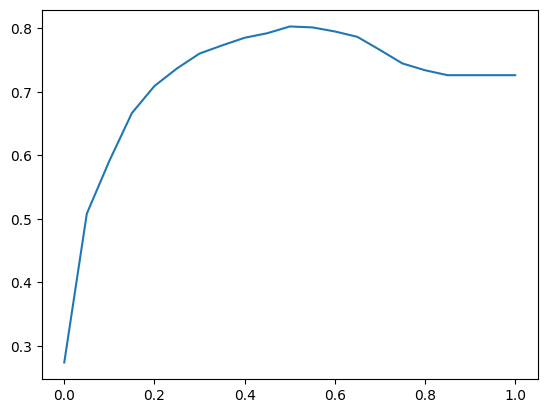

In [47]:
plt.plot(thresholds, scores)

Where the thresholds values are in the x-axis and the score are the y-axis

Scikit-learn also provides us with a built-in functions to calculate these accuracy.

In [48]:
from sklearn.metrics import accuracy_score

thresholds = np.linspace(0, 1, 21)

scores = []
for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.508
0.10 0.591
0.15 0.666
0.20 0.709
0.25 0.737
0.30 0.760
0.35 0.773
0.40 0.785
0.45 0.792
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.734
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


## Dummy (baseline) model and the problem with accruracy
Dummy/Baseline model accuracy is a simple reference point used to evaluate the performance of a machine learning model. It represents the accuracy you would achieve if you made predictions using a very basic or naive approach, often without any sophisticated modeling.

In our cases, if we build a dummy model in which the decision boundary is 1, which simply tell the algorithm that there will be no clients will churn, the accuracy would be around 73% (reference from the resutl above). Even with that naive threshold we still get a fairly well model, so why bother making another prediction to just gain an extra 7%?.

Therefore, in this problem accuracy can not tell us how good is the model because the dataset is **unbalanced**, which means that there are more instances from one category than the other. This is also known as **class imbalance**.

In [50]:
from collections import Counter
Counter(y_val)

Counter({np.int64(0): 1023, np.int64(1): 386})

## Confusion table


In [52]:
# people who are going to churn
actual_positive = (y_val == 1)
# people who are not going to churn
actual_negative = (y_val == 0)

t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

predict_positive & actual_positive
# Output: array([False, False, False, ..., False,  True,  True])
 
tp = (predict_positive & actual_positive).sum()
tp
# Output: 210
tn = (predict_negative & actual_negative).sum()
tn
# Output: 922
 
fp = (predict_positive & actual_negative).sum()
fp
# Output: 101
fn = (predict_negative & actual_positive).sum()
fn
# Output: 176

confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
 
confusion_matrix

array([[921, 102],
       [176, 210]])

## Precision and Recall
Precision tell us the fraction of positive predictions that are correct. It takes into account only the positive class (TP and FP - second column of the confusion matrix), as is stated in the following formula:

<div align="center">
\[
P = \frac{TP}{TP + FP}
\]
</div>

Recall measures the fraction of correctly identified postive instances. It considers parts of the positive and negative classes (TP and FN - second row of confusion table). The formula of this metric is presented below:

<div align="center">
\[
R = \frac{TP}{TP + FN}
\]
</div>

> Tips to remember:
> - Precision : From the predicted positives, how many we predicted right. See how the word `pre`cision is similar to the word `pre`diction?
> - Recall : From the real positives, how many we predicted right. See how the word `re`c`al`l is similar to the word `real`?

In summary, precision focuses on the accuracy of positive predictions, while recall emphasizes the model’s ability to capture all positive cases.

In [53]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print(accuracy, precision, recall, end = " ")

0.8026969481902059 0.6730769230769231 0.5440414507772021 

While accuracy can give a misleading impression of a model’s performance, metrics like precision and recall are much more informative, especially in situations with class imbalance. Precision and recall provide a more detailed understanding of how well the model is performing in identifying positive cases (in this case, churning customers).

In scenarios where correctly identifying specific cases is critical, such as identifying churning customers to prevent loss, precision and recall help us make more informed decisions and assess the trade-offs between correctly identifying positives and minimizing false positives or false negatives. So, relying solely on accuracy may not provide a complete picture of a model’s effectiveness for a particular task.

## ROC Curve (Receiver Operating Characteristics)
The Receiver Operating Characteristic (ROC) curve is a graphical representation used to evaluate the performance of a binary classification model. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold levels. The ROC curve helps visualize the trade-off between sensitivity and specificity (1 - FPR).

Where FPR is the fraction of false positives (FP) divided by the total number of negatives (FP and TN - the first row of confusion matrix), and we want to `minimize` it. The formula of FPR is the following:

<div align="center">
\[
FPR = \frac{FP}{TN + FP}
\]
</div>

On the other hand, TPR or Recall is the fraction of true positives (TP) divided by the total number of positives (FN and TP - second row of confusion table), and we want to `maximize` this metric. The formula of this measure is presented below:

<div align="center">
\[
TPR = \frac{TP}{TP + FN}
\]
</div>

It is possible to plot the ROC curves with FPR and Recall scores vs thresholds, or FPR vs Recall.

## ROC AUC
AUC stands for the Area Under Curve of the ROC Curve. It is a single scalar value the summarizes the overall perfomrance of a binary classification model by mearsing the area under the ROC curve. ROC AUC is considerably useful when dealing with imbalanced datasets because it looks at how well the classifier separates the classes, rather than just focusing on the most frequent class.

How can we interpret AUC value?:
- AUC = 1.0: This indicates a perfect classifier that has 100% True Positives and 0% False Positives, meaning it perfectly distinguishes between classes. 
- AUC =< 0.5: This indicates a classifier that performs no better than random guessing. The ROC curve would be a diagonal line from (0,0) to (1,1).
- AUC ~ 0.5: This means the classifier performs better than random. The closer the AUC is to 1, the better the model is at distinguishing between positive and negative classes.

## Cross validation
